In [1]:
# Loading required packages
library(plyr)
library(dplyr)
library(reshape)
library(ggplot2)
library(phyloseq)
library(metagenomeSeq)
library(biomformat)
library(interactiveDisplay)
library(wesanderson)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘reshape’

The following object is masked from ‘package:dplyr’:

    rename

The following objects are masked from ‘package:plyr’:

    rename, round_any

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following o

### Can start here with phyloseq file

In [2]:
ps = readRDS(file="CHTC/Dada2_Results_OA20_PEAR_Full/ps.fungi")

In [3]:
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5938 taxa and 101 samples ]
sample_data() Sample Data:       [ 101 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 5938 taxa by 16 taxonomic ranks ]

In [4]:
ps.norm = transform_sample_counts(ps, function(x) x/sum(x))

## Looking for l2fc as related to burn severity

Do we want to do this separately for different treatments? Initially, running it on the full dataset.

In [5]:
ps.biom = ps
# Copy phyloseq object
biom = make_biom(data = t(otu_table(ps.biom)), observation_metadata= tax_table(ps.biom), sample_metadata = sample_data(ps.biom))
# turn phyloseq into a biom table with OTU table, taxonomy, and sample data
biom.MRexp = biom2MRexperiment(biom)
# turns our biom file into the type of file needed for this analysis (an MRexperiment object)
biom.MRexp = biom.MRexp[,-which(is.na(pData(biom.MRexp)$pH))]
biom.MRexp

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

MRexperiment (storageMode: environment)
assayData: 5938 features, 94 samples 
  element names: counts 
protocolData: none
phenoData
  sampleNames: 15S-NT-19O 15S-NT-21O ... 15S-WB-U05O (94 total)
  varLabels: Barcodes Sample_ID ... Soil_Class (103 total)
  varMetadata: labelDescription
featureData
  featureNames: sq1 sq2 ... sq6383 (5938 total)
  fvarLabels: Kingdom Phylum ... Citation.Source (16 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

### Trying with including %C instead of Org_or_Min and Veg_Comm

In [6]:
MRexp = biom.MRexp 
MRexp = cumNorm(MRexp, cumNormStat(MRexp, qFlag=TRUE, pFlag = FALSE))
ModelData = pData(MRexp)
#ModelData$Understory_CBI = as.numeric(ModelData$Understory_CBI)
ModelData$pH = as.numeric(ModelData$pH)
ModelData$TC_pct = as.numeric(ModelData$TC_pct)
ModelData$Veg_Comm = make.names(ModelData$Veg_Comm)
ModelData$Burned_Unburned = as.factor(ModelData$Burned_Unburned)
ModelData$Burned_Unburned = ordered(ModelData$Burned_Unburned, levels = c('Unburned','Burned'))
#model = model.matrix(~Veg_Comm+TC_pct+pH+Understory_CBI, data=ModelData)
model = model.matrix(~Veg_Comm+TC_pct+pH+Burned_Unburned, data=ModelData)
settings = zigControl(tol = 1e-04, maxit = 30, verbose = TRUE, dfMethod = "default", pvalMethod = "default")
fit = fitZig(obj=MRexp, mod=model, control = settings, useCSSoffset = TRUE, zeroMod = NULL, useMixedModel = FALSE)

Default value being used.


it= 0, nll=125.06, log10(eps+1)=Inf, stillActive=5938
it= 1, nll=118.54, log10(eps+1)=Inf, stillActive=4941
it= 2, nll=116.33, log10(eps+1)=Inf, stillActive=3323
it= 3, nll=119.87, log10(eps+1)=Inf, stillActive=1822
it= 4, nll=120.32, log10(eps+1)=Inf, stillActive=1191
it= 5, nll=120.44, log10(eps+1)=Inf, stillActive=847
it= 6, nll=121.43, log10(eps+1)=Inf, stillActive=499
it= 7, nll=122.23, log10(eps+1)=Inf, stillActive=298
it= 8, nll=122.75, log10(eps+1)=Inf, stillActive=207
it= 9, nll=122.89, log10(eps+1)=Inf, stillActive=182
it=10, nll=122.93, log10(eps+1)=Inf, stillActive=174
it=11, nll=122.99, log10(eps+1)=Inf, stillActive=159
it=12, nll=123.03, log10(eps+1)=Inf, stillActive=152
it=13, nll=123.05, log10(eps+1)=Inf, stillActive=151
it=14, nll=123.07, log10(eps+1)=Inf, stillActive=149
it=15, nll=123.08, log10(eps+1)=Inf, stillActive=148
it=16, nll=123.09, log10(eps+1)=Inf, stillActive=148
it=17, nll=123.09, log10(eps+1)=Inf, stillActive=147
it=18, nll=123.09, log10(eps+1)=Inf, stil

In [7]:
EffSamp = calculateEffectiveSamples(fit)
MeanEffSamp = mean(EffSamp[!is.na(EffSamp)])
#MedianEffSamp = median(EffSamp[!is.na(EffSamp)])
# Effective sample size is calculates, and the average values of this is determined
rareFeatures = which(rowSums(MRcounts(MRexp) > 0) < MeanEffSamp)
# These are the taxa that that had less than the average number of effective samples
# As recommended in the vignette: https://www.bioconductor.org/packages/devel/bioc/vignettes/metagenomeSeq/inst/doc/metagenomeSeq.pdf
MRexp = MRexp[-rareFeatures, ]
# Take the data object and remove the rareFeatures (taxa)
# Re-run the analyses below.
MRexp = cumNorm(MRexp, cumNormStat(MRexp, qFlag=TRUE, pFlag = FALSE))
ModelData = pData(MRexp)

Default value being used.


In [8]:
ModelData$Understory_CBI = as.numeric(ModelData$Understory_CBI)
ModelData$pH = as.numeric(ModelData$pH)
ModelData$TC_pct = as.numeric(ModelData$TC_pct)
ModelData$Veg_Comm = make.names(ModelData$Veg_Comm)
ModelData$Burned_Unburned = as.factor(ModelData$Burned_Unburned)
ModelData$Burned_Unburned = ordered(ModelData$Burned_Unburned, levels = c('Unburned','Burned'))
#    model = model.matrix(~Veg_Comm+TC_pct+pH+Understory_CBI, data=ModelData)
model = model.matrix(~Veg_Comm+TC_pct+pH+Burned_Unburned, data=ModelData)
# Creating the model that we will use to analyze our data.
fit = fitZig(obj=MRexp, mod=model, control = settings, useCSSoffset = TRUE, zeroMod = NULL, useMixedModel = FALSE)
#Re-running the fit with the EffSamp - normalized data    

it= 0, nll=145.75, log10(eps+1)=Inf, stillActive=286
it= 1, nll=161.43, log10(eps+1)=0.02, stillActive=3
it= 2, nll=161.64, log10(eps+1)=0.00, stillActive=1
it= 3, nll=161.68, log10(eps+1)=0.00, stillActive=1
it= 4, nll=161.70, log10(eps+1)=0.00, stillActive=1
it= 5, nll=161.71, log10(eps+1)=0.00, stillActive=1
it= 6, nll=161.71, log10(eps+1)=0.00, stillActive=1
it= 7, nll=161.71, log10(eps+1)=0.00, stillActive=1
it= 8, nll=161.71, log10(eps+1)=0.00, stillActive=1
it= 9, nll=161.70, log10(eps+1)=0.00, stillActive=1
it=10, nll=161.70, log10(eps+1)=0.00, stillActive=1
it=11, nll=161.69, log10(eps+1)=0.00, stillActive=1
it=12, nll=161.69, log10(eps+1)=0.00, stillActive=1
it=13, nll=161.69, log10(eps+1)=0.00, stillActive=1
it=14, nll=161.68, log10(eps+1)=0.00, stillActive=1
it=15, nll=161.68, log10(eps+1)=0.00, stillActive=0


In [9]:
modeldesign = fit$fit$design
modelfit = fit$fit
modelfit.treat = treat(modelfit, lfc=0)

In [10]:
colnames(modelfit)

[1] "(Intercept)"           "Veg_CommJack.Pine"     "Veg_CommMixedwood"    
[4] "Veg_CommOpen.Wetland"  "Veg_CommTreed.Wetland" "TC_pct"               
[7] "pH"                    "Burned_Unburned.L"     "scalingFactor"

In [11]:
#resultsTC=topTreat(modelfit.treat, coef=2, number=7500)
resultsSeverity=topTreat(modelfit.treat, coef=8, number=7500)
#results=merge(resultsTC,resultsSeverity,by=0, all=TRUE, suffixes=c(".TC",".Severity"))
results=merge(data.frame(),resultsSeverity,by=0, all=TRUE, suffixes=c(".Severity"))

In [12]:
row.names(results)=results$Row.names
results= merge(results,fData(biom.MRexp),by=0,all=TRUE)
results = results[,2:dim(results)[2]]
colnames(results)[1]="OTU"
#results$sigTC = ifelse(results$adj.P.Val.TC<0.05,1,0.5)
results$sigSeverity = ifelse(results$adj.P.Val<0.05,1,0.5)

Warning message in merge.data.frame(results, fData(biom.MRexp), by = 0, all = TRUE):
“column name ‘Row.names’ is duplicated in the result”

In [13]:
colnames(results)

[1] "OTU"                "logFC"              "AveExpr"           
 [4] "t"                  "P.Value"            "adj.P.Val"         
 [7] "Kingdom"            "Phylum"             "Class"             
[10] "Order"              "Family"             "Genus"             
[13] "Species"            "OTU_ID"             "Taxon"             
[16] "Taxon.Level"        "Trophic.Mode"       "Guild"             
[19] "Growth.Morphology"  "Confidence.Ranking" "Notes"             
[22] "Citation.Source"    "sigSeverity"

In [14]:
mdf = psmelt(ps.norm)

In [15]:
OTUTable = data.frame(OTU=row.names(t(otu_table(ps.norm))),(t(otu_table(ps.norm))))
head(OTUTable)

,OTU,X15S.NT.19O,X15S.NT.20O,X15S.NT.21M,X15S.NT.21O,X15S.NT.22M,X15S.NT.22O,X15S.NT.23M,X15S.NT.23O,X15S.NT.24M,⋯,X15S.WB.18M,X15S.WB.U01M,X15S.WB.U01O,X15S.WB.U02O,X15S.WB.U03M,X15S.WB.U03O,X15S.WB.U04M,X15S.WB.U04O,X15S.WB.U05M,X15S.WB.U05O
sq1,sq1,0.216761016,0.0006690977,0.007252652,1.635174e-03,0.2203714088,0.6912684928,0.0017385807,0.0019758133,0.0502506517,⋯,0.002372001,0.0277424049,1.280534e-01,0.078311039,0.0009353079,0.1016153103,1.269841e-03,0.0115094524,0.0133813287,0.1163017032
sq2,sq2,0.016715116,0.0019738383,0.002670131,1.816860e-04,0.1373486823,0.0520077908,0.3358621780,0.1133708057,0.0011229196,⋯,0.172529538,0.0353829361,1.083437e-02,0.014184918,0.0999610288,0.0285751909,2.428571e-02,0.0854148301,0.0486736051,0.0491484185
sq3,sq3,0.000000000,0.0087651802,0.000000000,4.844961e-04,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,⋯,0.000000000,0.0000000000,3.997921e-05,0.052072615,0.0000000000,0.0000000000,0.000000e+00,0.0000000000,0.0018780812,0.0000000000
sq4,sq4,0.004016218,0.0003345489,0.049686079,0.000000e+00,0.0003958175,0.0003729642,0.0001185396,0.1614035088,0.0041708442,⋯,0.165995346,0.0000909587,5.693040e-02,0.002168161,0.0000000000,0.0000000000,0.000000e+00,0.0000000000,0.0004695203,0.0000973236
sq5,sq5,0.006272950,0.0180990934,0.002345385,3.633721e-04,0.0088069400,0.0372549832,0.0018176071,0.0009538409,0.0005213555,⋯,0.014008235,0.0004547935,9.882861e-02,0.054461267,0.0000000000,0.0005706259,5.291005e-05,0.0007346459,0.0035996557,0.0000973236
sq6,sq6,0.001568237,0.0003680037,0.000000000,6.056202e-05,0.0086750008,0.0309145912,0.0001580528,0.0178504514,0.0050531382,⋯,0.009756534,0.0000909587,1.839044e-02,0.002572395,0.0000000000,0.0001316829,1.587302e-04,0.0002448820,0.0000000000,0.0000000000


In [16]:
df = results %>%
    mutate(Responder = ifelse(logFC>0,ifelse(adj.P.Val<0.05,"Positive Sig","Positive"),
                             ifelse(adj.P.Val<0.05,"Negative Sig","Negative")))

df$Responder = as.factor(df$Responder)
df$Responder = ordered(df$Responder, levels=c("Positive Sig","Positive","Not Tested","Negative","Negative Sig"))
df$Responder[is.na(df$Responder)] = "Not Tested"

In [17]:
df.merged = merge(x=mdf,y=df[,c('OTU',"Responder",'logFC','adj.P.Val',"AveExpr","sigSeverity")],by="OTU", all.x=TRUE)
df.merged$Responder[is.na(df.merged$Responder)] = "Not Tested"

In [18]:
#saveRDS(df.merged,file="CHTC/Dada2_Results_OA20_PEAR_Full/l2fcFull.df")
df.Merged = readRDS("CHTC/Dada2_Results_OA20_PEAR_Full/l2fcFull.df")
#results=df.Merged

In [19]:
levels(as.factor((results)$Phylum))

[1] ""                  "Ascomycota"        "Basidiomycota"    
[4] "Chytridiomycota"   "Glomeromycota"     "Mortierellomycota"
[7] "Mucoromycota"      "Rozellomycota"     "unidentified"

In [26]:
nTax=20
TaxOrder[1:nTax]

[1] "Trichocomaceae"      "Unidentified"        "Myxotrichaceae"     
 [4] "Umbelopsidaceae"     "Herpotrichiellaceae" "Mortierellaceae"    
 [7] "Pleosporales"        "Hypocreaceae"        "Venturiaceae"       
[10] "Eurotiomycetes"      "Mucoraceae"          "Suillaceae"         
[13] "Cystobasidiaceae"    "Pleosporaceae"       "Helotiales"         
[16] "Vibrisseaceae"       "Clavicipitaceae"     "Cordycipitaceae"    
[19] "Sordariaceae"        "Valsaceae"

In [27]:
FullResults = results%>%
    filter(!is.na(OTU))%>%
    arrange(Phylum)

FullResults = FullResults[!is.na(FullResults$Class),]
FullResults = FullResults[FullResults$Class!='',]
FullResults = FullResults[FullResults$Class!='unidentified',]

FullResults$FixedClass[FullResults$Class=="Pezizomycotina_cls_Incertae_sedis"] = "Pezizomycotina subdiv"
FullResults$FixedClass[FullResults$Class=="Pucciniomycotina_cls_Incertae_sedis"] = "Pucciniomycotina subdiv"
FullResults$FixedClass[FullResults$Class=="Mortierellomycotina_cls_Incertae_sedis"] = "Mortierellomycotina subdiv"
FullResults$FixedClass[is.na(FullResults$FixedClass)] = paste(FullResults$Class[is.na(FullResults$FixedClass)])

FullResults$FixedFam[FullResults$Family=="Eurotiomycetes_fam_Incertae_sedis"] = "Eurotiomycetes"
FullResults$FixedFam[FullResults$Family=="Helotiales_fam_Incertae_sedis"] = "Helotiales"
FullResults$FixedFam[FullResults$Family=="Leotiomycetes_fam_Incertae_sedis"] = "Leotiomycetes"
FullResults$FixedFam[FullResults$Family=="Pezizomycotina_fam_Incertae_sedis"] = "Pezizomycotina"
FullResults$FixedFam[FullResults$Family=="Pleosporales_fam_Incertae_sedis"] = "Pleosporales"
FullResults$FixedFam[FullResults$Family=="Pucciniomycotina_fam_Incertae_sedis"] = "Pucciniomycotina"
FullResults$FixedFam[FullResults$Family=="Sporidiobolales_fam_Incertae_sedis"] = "Sporidiobolales"
FullResults$FixedFam[FullResults$Family==""] = "Unidentified"
FullResults$FixedFam[FullResults$Family=="unidentified"] = "Unidentified"
FullResults$FixedFam[is.na(FullResults$FixedFam)] = paste(FullResults$Family[is.na(FullResults$FixedFam)])


TaxOrder = FullResults%>%
    group_by(FixedClass, FixedFam,Phylum,Guild)%>%
    summarize(TotalOTUs=n())%>%
    arrange(-TotalOTUs)
GuildOrder = as.factor(TaxOrder$Guild)
TaxOrder = TaxOrder$FixedFam
TaxOrder = unique(TaxOrder)
#FullResults$FixedClass = ordered(FullResults$FixedClass, levels=TaxOrder)
FullResults$FixedFam = as.factor(FullResults$FixedFam)
FullResults$FixedFam = ordered(FullResults$FixedFam, levels=TaxOrder)

In [30]:
LTSP = c("Geoglossum","Gibberella","Preussia","Thelephora","Rhizoscyphus","Rhizosphaera","Mollisia",
        "Laccaria","Podospora","Hormonema","Talaromyces","Cryptococcus","Sagenomella","Cryptosporiopsis",
        "Venturia","Suillus","Tricholoma","Hygrophorus","Capronia","Cladophialophora","Mycena","Penicillium")

In [31]:
FullResults$LTSP = ""
FullResults$LTSP[FullResults$Genus %in% LTSP]="Yes"

In [35]:
FullResults[FullResults$LTSP=="Yes" & !is.na(FullResults$OTU),c("OTU","logFC","AveExpr","Family","Genus")]

,OTU,logFC,AveExpr,Family,Genus
17,sq1,1.071922505,8.0726828,Trichocomaceae,Penicillium
19,sq100,0.885527050,2.6828531,Trichocomaceae,Penicillium
22,sq1032,0.500229323,0.4505801,Trichocomaceae,Penicillium
26,sq11,1.970228680,3.9487787,Trichocomaceae,Penicillium
31,sq1163,-0.074973405,0.4738931,Herpotrichiellaceae,Capronia
33,sq119,0.950320278,2.3154749,Trichocomaceae,Penicillium
42,sq141,-0.804155869,1.8128430,Herpotrichiellaceae,Cladophialophora
46,sq148,-0.125905375,1.8726336,Herpotrichiellaceae,Cladophialophora
56,sq173,0.773908115,2.0107365,Trichocomaceae,Penicillium
60,sq182,0.068881860,2.2616312,Trichocomaceae,Penicillium


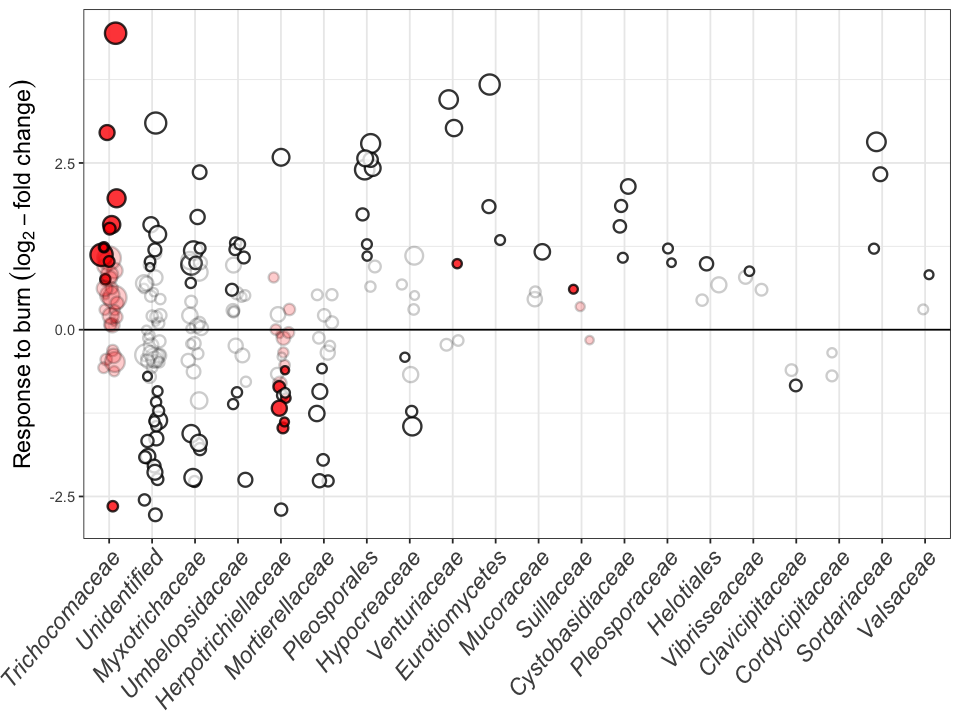

In [32]:
options(repr.plot.width=8, repr.plot.height=6)

FullResults$sigSeverity = as.factor(FullResults$sigSeverity)

p = ggplot(FullResults[FullResults$FixedFam %in% TaxOrder[1:nTax],],aes(x=FixedFam, y=logFC, alpha=sigSeverity, fill=LTSP))
p = p + geom_jitter(shape=21, stroke=1, aes(size=AveExpr), width=0.2)
p = p + scale_size(guide=FALSE)
p = p + scale_alpha_manual(guide=FALSE, values=c(0.2,0.8))
p = p + scale_fill_manual(values=c("white","red","white"))
p = p + theme_bw()
p = p + theme(axis.text.x = element_text(angle=50, hjust=1, size=14))
p = p + theme(axis.title.y = element_text(size=14))
p = p + theme(legend.position="none")
p = p + geom_hline(yintercept=0) 
p = p + ylab(expression(Response~to~burn~(log[2]-fold~change)))
p = p + theme(axis.text.x = element_text(face="italic"),
             legend.text = element_text(face="italic"),
             axis.title.x = element_blank())
p

In [178]:
colnames(FullResults)

[1] "OTU"                "logFC"              "AveExpr"           
 [4] "t"                  "P.Value"            "adj.P.Val"         
 [7] "Kingdom"            "Phylum"             "Class"             
[10] "Order"              "Family"             "Genus"             
[13] "Species"            "OTU_ID"             "Taxon"             
[16] "Taxon.Level"        "Trophic.Mode"       "Guild"             
[19] "Growth.Morphology"  "Confidence.Ranking" "Notes"             
[22] "Citation.Source"    "sigSeverity"        "FixedClass"        
[25] "FixedFam"

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'FixedFam' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(capture.output(print(obj)), collapse = "\n")
10. capture.output(print(obj))
11. evalVis(expr)
12. withVisible(eval(expr, pf))
13. eval(expr, pf)
14. eval(expr, pf)
15. print(obj)
16. print.ggplot(obj)
17. ggplot_build(x)
18. by_layer(function(l, d) l$comp

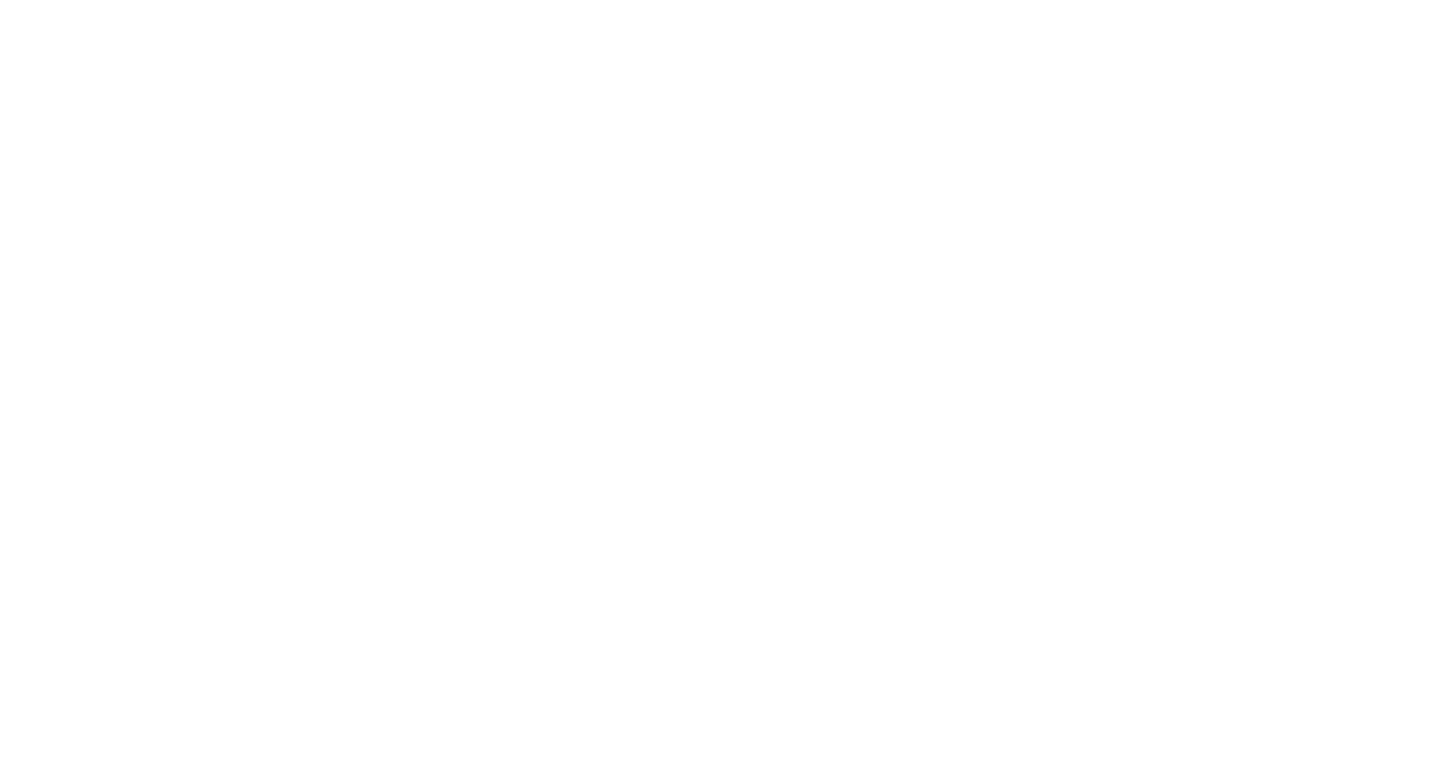

In [184]:
options(repr.plot.width=12, repr.plot.height=6.5)

nTax=35

D = FullResults[FullResults$FixedFam %in% TaxOrder[1:nTax],]
D$AveExpr = D$AveExpr*100

p = ggplot(D,aes(x=FixedFam, y=logFC, alpha=sigSeverity, fill=Phylum))
p = p + geom_jitter(shape=21, stroke=1, aes(size=(AveExpr)), width=0.2)
p = p + scale_size(guide=FALSE)
p = p + scale_alpha(guide=FALSE)
p = p + theme(axis.text.x = element_text(angle=45, hjust=1))
#p = p + scale_fill_manual(values=c(wes_palette("Royal1")[1:4],wes_palette("Darjeeling"),wes_palette("GrandBudapest"),wes_palette("GrandBudapest")))
#p = p + facet_wrap(~Phylum,scales="free_x")
#p = p + theme(legend.position="none")
p = p + geom_hline(yintercept=0) 
p = p + ylab("Response to burn (log2-fold change)")
p = p + theme_bw()
p = p + ylab(expression(Response~to~burn~(log[2]-fold~change)))
p = p + theme(axis.text.x = element_text(angle=55, hjust=1, face="italic", size=14),
              axis.text.y = element_text(size=14),
             legend.text = element_text(face="italic",size=14),
             axis.title.x = element_blank(),
             legend.position ="right",
              axis.title.y = element_text(size=20))
p = p + guides(fill=guide_legend(ncol=1,title="",override.aes = list(size=10)))
p

In [22]:
TopResponders = FullResults%>% 
    arrange(-logFC)
write.csv(TopResponders[1:25,], file="CHTC/Dada2_Results_OA20_PEAR_Full/TopBurnResponders.csv")

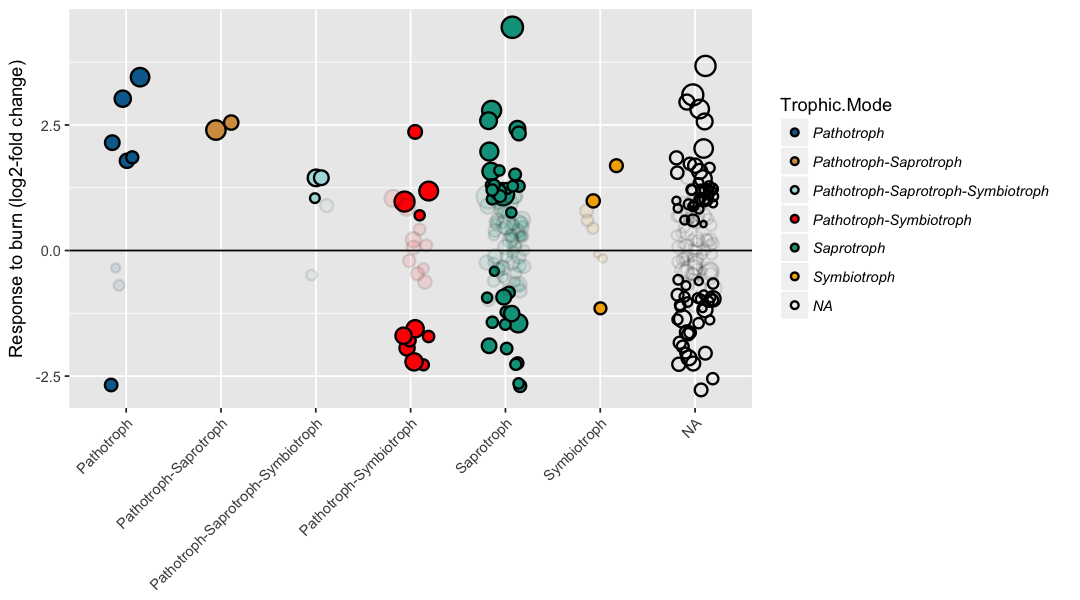

In [180]:
options(repr.plot.width=9, repr.plot.height=5)

FullResults = results%>%
    filter(!is.na(OTU))%>%
    arrange(Phylum)



p = ggplot(FullResults,aes(x=Trophic.Mode, y=logFC, alpha=sigSeverity, fill=Trophic.Mode))
p = p + geom_jitter(shape=21, stroke=1, aes(size=AveExpr), width=0.2)
p = p + scale_size(guide=FALSE)
p = p + scale_alpha(guide=FALSE)
p = p + theme(axis.text.x = element_text(angle=45, hjust=1))
p = p + scale_fill_manual(values=c(wes_palette("Darjeeling2")[2:4],wes_palette("Darjeeling"),wes_palette("Darjeeling2"),wes_palette("GrandBudapest")))
#p = p + facet_wrap(~Phylum,scales="free_x")
#p = p + theme(legend.position="none")
p = p + geom_hline(yintercept=0) 
p = p + ylab("Response to burn (log2-fold change)")
p = p + theme(
             legend.text = element_text(face="italic"),
             axis.title.x = element_blank())
p

## Summarizing results

In [181]:
df.merged = df.merged%>%
    group_by(OTU,Veg_Comm,Burned_Unburned,Severity_Class,Trophic.Mode,Guild,Responder,Phylum,Class,Order,Family,Genus,Species)%>%
    summarize(MeanAbundance=mean(Abundance))
# Want to plot the average abundance of a given taxon.
# So, to summarize by OTU, I guess.

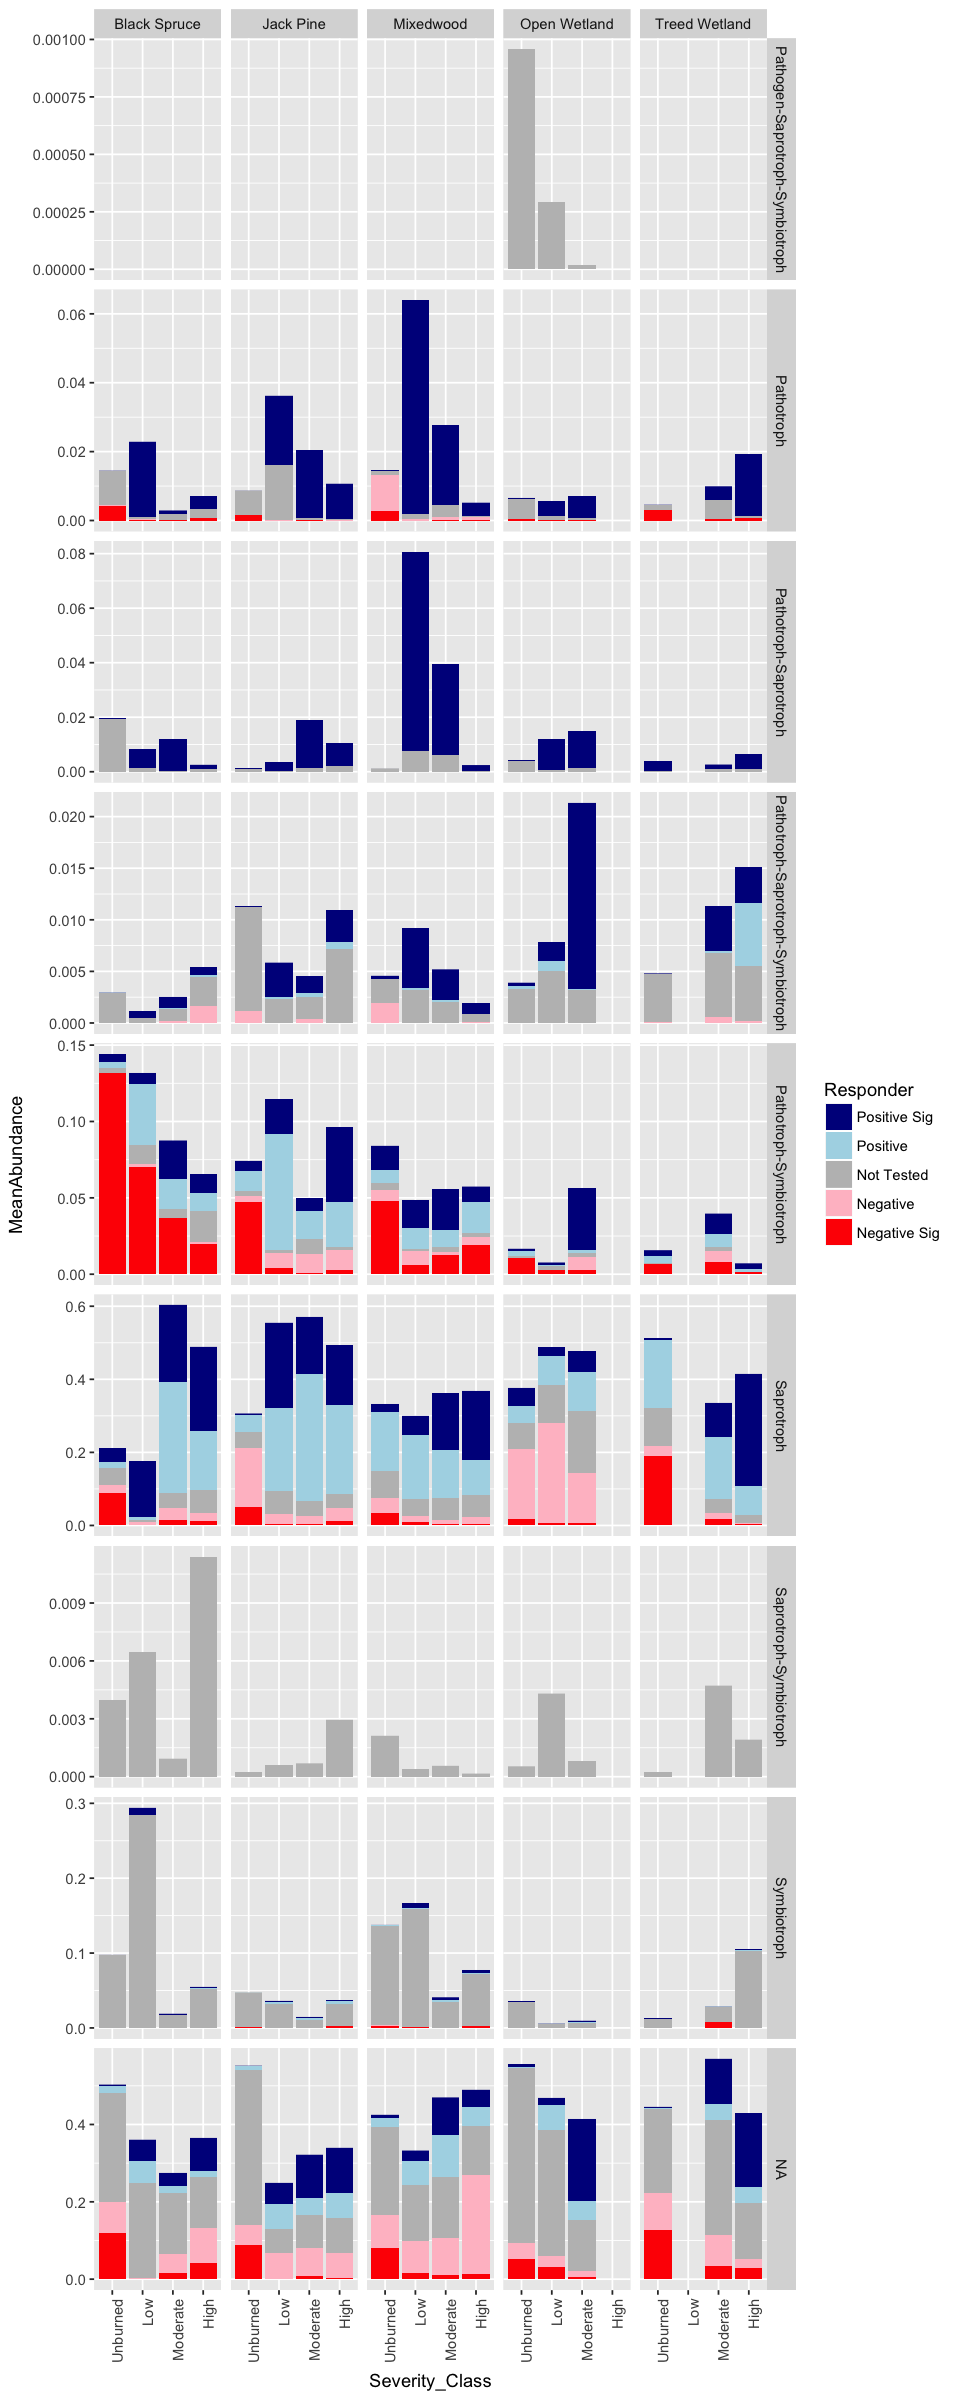

In [182]:
options(repr.plot.width=8, repr.plot.height=20)
df.plot = df.merged%>%
    group_by(Veg_Comm, Trophic.Mode)%>%
    filter(sum(MeanAbundance)>0.001)#%>%
    #filter(Burned_Unburned == "Burned")

p = ggplot(df.plot, aes(x=Severity_Class, y=MeanAbundance, fill=Responder))
#p = p +  geom_col(position="fill")
p = p +  geom_col()
p = p + scale_fill_manual(values=c("darkblue","lightblue","grey","pink","red"))
p = p + theme(axis.text.x = element_text(angle = 90, hjust=1))
#p = p + geom_abline(slope=0,intercept=0.5)
p = p + facet_grid(~Trophic.Mode~Veg_Comm,labeller = label_wrap_gen(),scales="free_y")
p
# This figure shows the mean relative abundance of all taxa, coloured by whether of not they were identified as
# general responders. I think it is interesting to see that, of the Saprotrophs, they tended to be 
# positively associated with fire severity. Most symbiotrophs were not abundant enough to be tested - 
# could play around with adjusting parameters to get more Ectos through the pipeline.


In [183]:
d = df.merged%>%
    filter(Family=="Venturiaceae" & Responder == "Positive Sig")%>%
    arrange(-Abundance)
d[,c("Phylum","Class","Order","Family","Genus","Species","OTU","Abundance")]

ERROR: Error in arrange_impl(.data, dots): Evaluation error: object 'Abundance' not found.


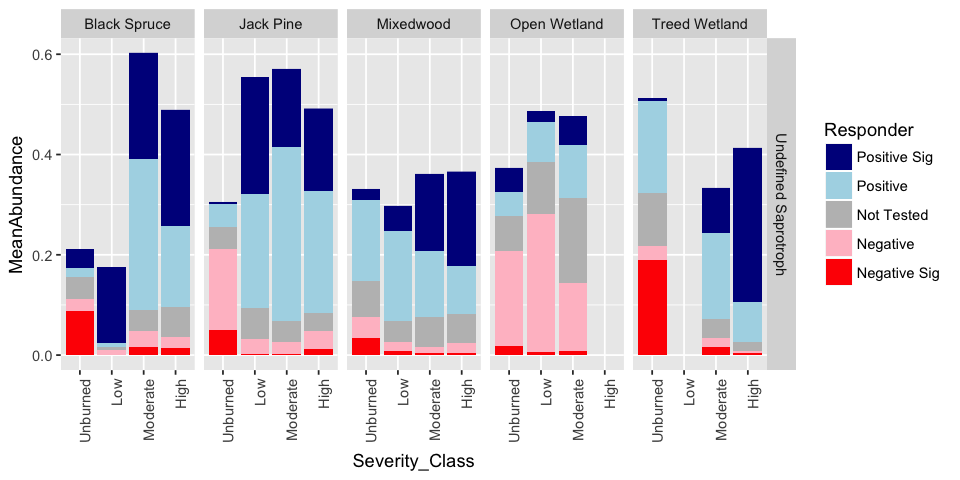

In [28]:
options(repr.plot.width=8, repr.plot.height=4)
df.plot = df.merged%>%
    group_by(Veg_Comm, Guild)%>%
    filter(sum(MeanAbundance)>0.001)%>%
    filter(Guild == "Undefined Saprotroph")

p = ggplot(df.plot, aes(x=Severity_Class, y=MeanAbundance, fill=Responder))
#p = p +  geom_col(position="fill")
p = p +  geom_col()
p = p + scale_fill_manual(values=c("darkblue","lightblue","grey","pink","red"))
p = p + theme(axis.text.x = element_text(angle = 90, hjust=1))
#p = p + geom_abline(slope=0,intercept=0.5)
p = p + facet_grid(~Guild~Veg_Comm,labeller = label_wrap_gen(),scales="free_y")
p
# This figure shows the mean relative abundance of all taxa, coloured by whether of not they were identified as
# general responders. I think it is interesting to see that, of the Saprotrophs, they tended to be 
# positively associated with fire severity. Most symbiotrophs were not abundant enough to be tested - 
# could play around with adjusting parameters to get more Ectos through the pipeline.


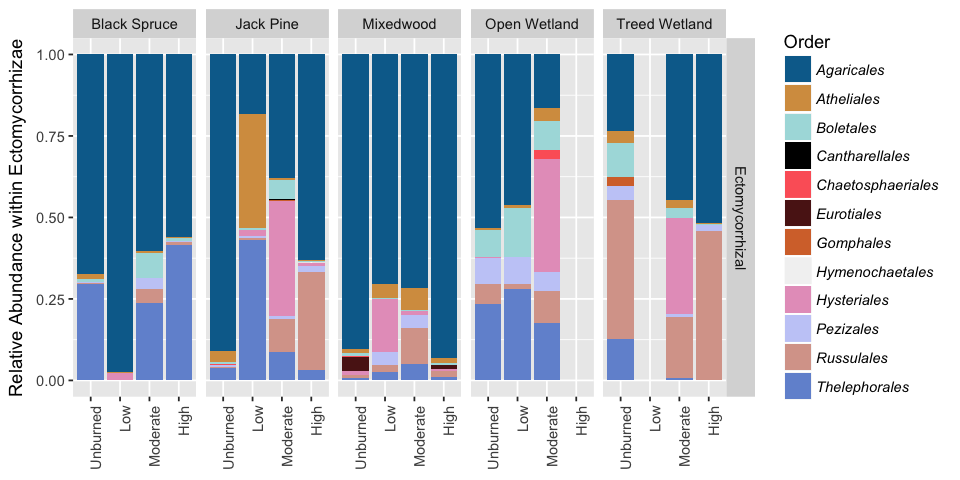

In [29]:
options(repr.plot.width=8, repr.plot.height=4)
df.plot = df.merged%>%
    group_by(Veg_Comm, Guild)%>%
    filter(sum(MeanAbundance)>0.001)%>%
    #filter(Guild %in% c('Ectomycorrhizal' ,'Ectomycorrhizal-Endophyte-Ericoid Mycorrhizal-Litter Saprotroph-Orchid Mycorrhizal', 'Ectomycorrhizal-Lichen Parasite-Lichenized-Plant Pathogen' ,'Ectomycorrhizal-Orchid Mycorrhizal-Root Associated Biotroph', 'Ectomycorrhizal-Undefined Saprotroph' ,'Ectomycorrhizal-Wood Saprotroph'))
    filter(Guild %in% c('Ectomycorrhizal'))%>%
    group_by(Veg_Comm,Severity_Class)%>%
    mutate(Relabund=MeanAbundance/sum(MeanAbundance))

p = ggplot(df.plot, aes(x=Severity_Class, y=Relabund, fill=Order))
#p = p +  geom_col(position="fill")
p = p +  geom_col()
#p = p + scale_fill_manual(values=c("darkblue","lightblue","grey","pink","red"))
p = p + scale_fill_manual(values=c(wes_palette("Darjeeling2")[2:5],wes_palette("GrandBudapest")[2:5],wes_palette("GrandBudapest2"),wes_palette("GrandBudapest")))
p = p + theme(axis.text.x = element_text(angle = 90, hjust=1))
#p = p + geom_abline(slope=0,intercept=0.5)
p = p + facet_grid(~Guild~Veg_Comm,labeller = label_wrap_gen(),scales="free_y")
p = p + ylab("Relative Abundance within Ectomycorrhizae")
p = p + theme(
             legend.text = element_text(face="italic"),
             axis.title.x = element_blank())
p
# This figure shows the mean relative abundance of all taxa, coloured by whether of not they were identified as
# general responders. I think it is interesting to see that, of the Saprotrophs, they tended to be 
# positively associated with fire severity. Most symbiotrophs were not abundant enough to be tested - 
# could play around with adjusting parameters to get more Ectos through the pipeline.

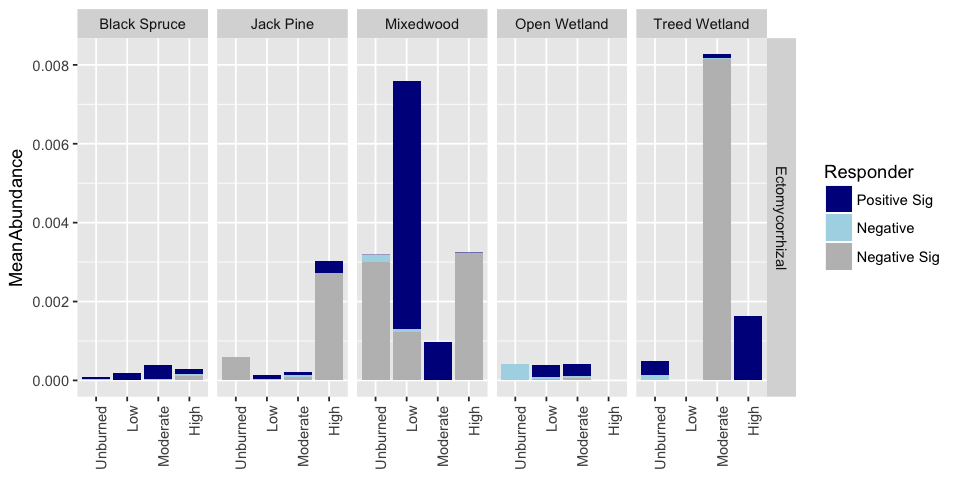

In [30]:
options(repr.plot.width=8, repr.plot.height=4)
df.plot = df.merged%>%
    group_by(Veg_Comm, Guild)%>%
    filter(sum(MeanAbundance)>0.001)%>%
    #filter(Guild %in% c('Ectomycorrhizal' ,'Ectomycorrhizal-Endophyte-Ericoid Mycorrhizal-Litter Saprotroph-Orchid Mycorrhizal', 'Ectomycorrhizal-Lichen Parasite-Lichenized-Plant Pathogen' ,'Ectomycorrhizal-Orchid Mycorrhizal-Root Associated Biotroph', 'Ectomycorrhizal-Undefined Saprotroph' ,'Ectomycorrhizal-Wood Saprotroph'))
    filter(Guild %in% c('Ectomycorrhizal'))%>%
    filter(Responder != "Not Tested")

p = ggplot(df.plot, aes(x=Severity_Class, y=MeanAbundance, fill=Responder))
#p = p +  geom_col(position="fill")
p = p +  geom_col()
p = p + scale_fill_manual(values=c("darkblue","lightblue","grey","pink","red"))
#p = p + scale_fill_manual(values=c(wes_palette("Darjeeling2")[2:5],wes_palette("GrandBudapest")[2:5],wes_palette("GrandBudapest2"),wes_palette("GrandBudapest")))
p = p + theme(axis.text.x = element_text(angle = 90, hjust=1))
#p = p + geom_abline(slope=0,intercept=0.5)
p = p + facet_grid(~Guild~Veg_Comm,labeller = label_wrap_gen(),scales="free_y")
p = p + theme(axis.title.x = element_blank())
p

In [192]:
df.plot = df.plot %>%
    arrange(-MeanAbundance)
head(df.plot)

OTU,Veg_Comm,Burned_Unburned,Severity_Class,Trophic.Mode,Guild,Responder,Phylum,Class,Order,Family,Genus,Species,MeanAbundance
sq34,Black Spruce,Burned,Low,Symbiotroph,Ectomycorrhizal,Not Tested,Basidiomycota,Agaricomycetes,Agaricales,Cortinariaceae,Cortinarius,Cortinarius_mucosus,0.18104447
sq133,Black Spruce,Unburned,Unburned,Symbiotroph,Ectomycorrhizal,Not Tested,Basidiomycota,Agaricomycetes,Agaricales,Cortinariaceae,Cortinarius,Cortinarius_saturninus,0.04938119
sq42,Mixedwood,Burned,Low,Symbiotroph,Ectomycorrhizal,Not Tested,Basidiomycota,Agaricomycetes,Agaricales,Inocybaceae,Inocybe,,0.03991014
sq59,Mixedwood,Unburned,Unburned,Symbiotroph,Ectomycorrhizal,Not Tested,Basidiomycota,Agaricomycetes,Agaricales,Inocybaceae,Inocybe,,0.03516006
sq203,Black Spruce,Burned,Low,Symbiotroph,Ectomycorrhizal,Not Tested,Basidiomycota,Agaricomycetes,Agaricales,Cortinariaceae,Cortinarius,Cortinarius_mucosus,0.03122640
sq36,Mixedwood,Burned,Low,Symbiotroph,Ectomycorrhizal,Not Tested,Basidiomycota,Agaricomycetes,Agaricales,Inocybaceae,Inocybe,,0.03120146


In [198]:
d = sample_data(ps.norm)
d = d %>%
    group_by(Veg_Comm,Severity_Class)%>%
    summarize(n())
d

Veg_Comm,Severity_Class,n()
Black Spruce,Unburned,4
Black Spruce,Low,2
Black Spruce,Moderate,4
Black Spruce,High,6
Jack Pine,Unburned,4
Jack Pine,Low,4
Jack Pine,Moderate,8
Jack Pine,High,15
Mixedwood,Unburned,8
Mixedwood,Low,8


In [202]:
colnames(df)

[1] "OTU"                "logFC"              "AveExpr"           
 [4] "t"                  "P.Value"            "adj.P.Val"         
 [7] "Kingdom"            "Phylum"             "Class"             
[10] "Order"              "Family"             "Genus"             
[13] "Species"            "OTU_ID"             "Taxon"             
[16] "Taxon.Level"        "Trophic.Mode"       "Guild"             
[19] "Growth.Morphology"  "Confidence.Ranking" "Notes"             
[22] "Citation.Source"    "sigSeverity"        "Responder"

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
df.plot = df.merged%>%
    group_by(Veg_Comm, Guild)%>%
    filter(Org_or_Min=="O")%>%
    filter(sum(MeanAbundance)>0)%>%
    #filter(Guild %in% c('Ectomycorrhizal' ,'Ectomycorrhizal-Endophyte-Ericoid Mycorrhizal-Litter Saprotroph-Orchid Mycorrhizal', 'Ectomycorrhizal-Lichen Parasite-Lichenized-Plant Pathogen' ,'Ectomycorrhizal-Orchid Mycorrhizal-Root Associated Biotroph', 'Ectomycorrhizal-Undefined Saprotroph' ,'Ectomycorrhizal-Wood Saprotroph'))
    filter(Guild %in% c('Ectomycorrhizal'))

p = ggplot(df.plot, aes(x=Severity_Class, y=MeanAbundance, fill=Genus))
#p = p +  geom_col(position="fill")
p = p +  geom_col()
#p = p + scale_fill_manual(values=c("darkblue","lightblue","grey","pink","red"))
#p = p + scale_fill_manual(values=c(wes_palette("Darjeeling2")[2:5],wes_palette("GrandBudapest")[2:5],wes_palette("GrandBudapest2"),wes_palette("GrandBudapest")))
p = p + theme(axis.text.x = element_text(angle = 90, hjust=1))
#p = p + geom_abline(slope=0,intercept=0.5)
p = p + facet_grid(~Guild~Veg_Comm,labeller = label_wrap_gen(),scales="free_y")
p = p + theme(axis.title.x = element_blank())
p = p + guides(position="bottom") + theme(legend.position="bottom")
p

In [199]:
options(repr.plot.width=8, repr.plot.height=8)
df.plot = df.merged%>%
    group_by(Veg_Comm, Guild)%>%
    filter(Org_or_Min=="O")%>%
    filter(sum(MeanAbundance)>0)%>%
    #filter(Guild %in% c('Ectomycorrhizal' ,'Ectomycorrhizal-Endophyte-Ericoid Mycorrhizal-Litter Saprotroph-Orchid Mycorrhizal', 'Ectomycorrhizal-Lichen Parasite-Lichenized-Plant Pathogen' ,'Ectomycorrhizal-Orchid Mycorrhizal-Root Associated Biotroph', 'Ectomycorrhizal-Undefined Saprotroph' ,'Ectomycorrhizal-Wood Saprotroph'))
    filter(Guild %in% c('Ectomycorrhizal'))

p = ggplot(df.plot, aes(x=Severity_Class, y=MeanAbundance, fill=Genus))
#p = p +  geom_col(position="fill")
p = p +  geom_col()
#p = p + scale_fill_manual(values=c("darkblue","lightblue","grey","pink","red"))
#p = p + scale_fill_manual(values=c(wes_palette("Darjeeling2")[2:5],wes_palette("GrandBudapest")[2:5],wes_palette("GrandBudapest2"),wes_palette("GrandBudapest")))
p = p + theme(axis.text.x = element_text(angle = 90, hjust=1))
#p = p + geom_abline(slope=0,intercept=0.5)
p = p + facet_grid(~Guild~Veg_Comm,labeller = label_wrap_gen(),scales="free_y")
p = p + theme(axis.title.x = element_blank())
p = p + guides(position="bottom") + theme(legend.position="bottom")
p

ERROR: Error in filter_impl(.data, quo): Evaluation error: object 'Org_or_Min' not found.


In [208]:
head(df.merged)

OTU,Veg_Comm,Burned_Unburned,Severity_Class,Trophic.Mode,Guild,Responder,Phylum,Class,Order,Family,Genus,Species,MeanAbundance
sq1,Black Spruce,Burned,Low,Saprotroph,Undefined Saprotroph,Positive,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Penicillium,,0.003730603
sq1,Black Spruce,Burned,Moderate,Saprotroph,Undefined Saprotroph,Positive,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Penicillium,,0.155500820
sq1,Black Spruce,Burned,High,Saprotroph,Undefined Saprotroph,Positive,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Penicillium,,0.088984548
sq1,Black Spruce,Unburned,Unburned,Saprotroph,Undefined Saprotroph,Positive,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Penicillium,,0.009239928
sq1,Jack Pine,Burned,Low,Saprotroph,Undefined Saprotroph,Positive,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Penicillium,,0.050231423
sq1,Jack Pine,Burned,Moderate,Saprotroph,Undefined Saprotroph,Positive,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Penicillium,,0.121712243


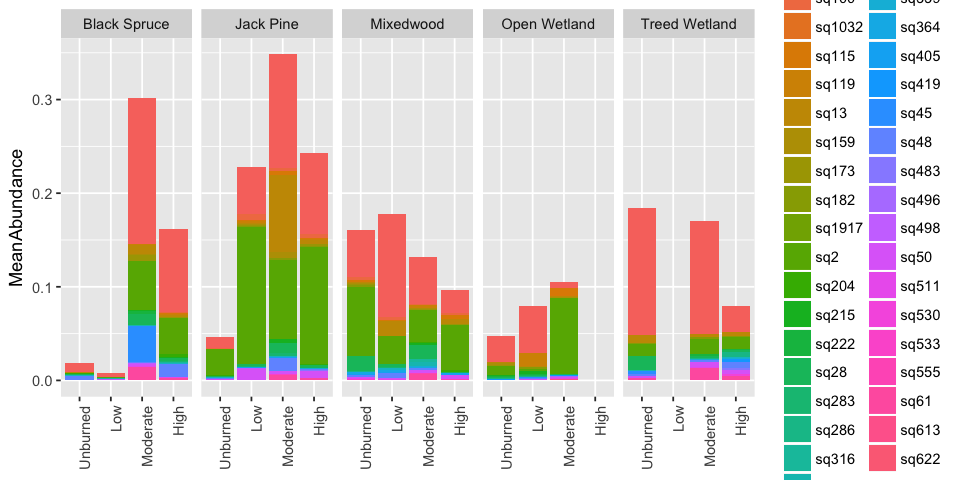

In [210]:
options(repr.plot.width=8, repr.plot.height=4)
df.plot = df.merged%>%
    filter(Guild %in% c('Undefined Saprotroph'))%>%
    filter(Responder=="Positive")

p = ggplot(df.plot, aes(x=Severity_Class, y=MeanAbundance, fill=OTU))
#p = p +  geom_col(position="fill")
p = p +  geom_col()
#p = p + scale_fill_manual(values=c("darkblue","lightblue","grey","pink","red"))
#p = p + scale_fill_manual(values=c(wes_palette("Darjeeling2")[2:5],wes_palette("GrandBudapest")[2:5],wes_palette("GrandBudapest2"),wes_palette("GrandBudapest")))
p = p + theme(axis.text.x = element_text(angle = 90, hjust=1))
#p = p + geom_abline(slope=0,intercept=0.5)
p = p + facet_grid(~Veg_Comm,labeller = label_wrap_gen(),scales="free_y")
p = p + theme(axis.title.x = element_blank())
p

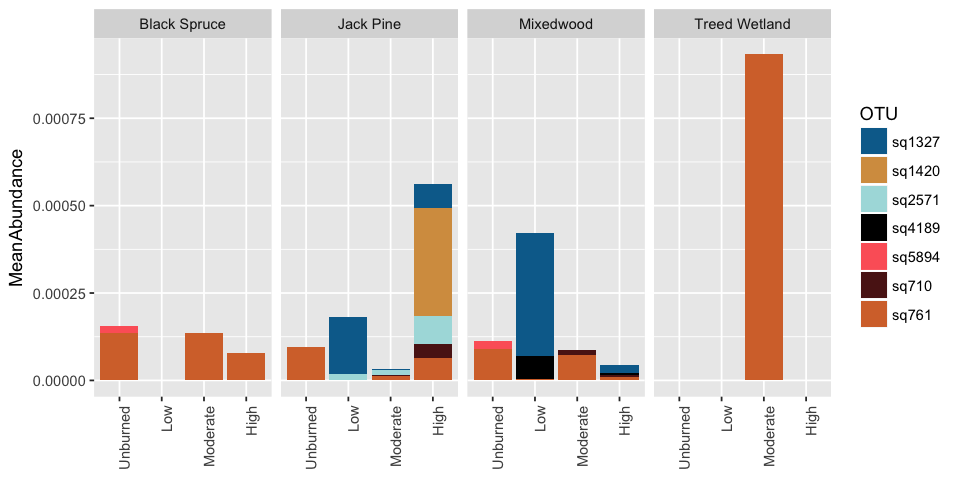

In [32]:
options(repr.plot.width=8, repr.plot.height=4)
df.plot = df.merged%>%
    filter(Family %in% c('Morchellaceae'))%>%
    filter(Veg_Comm!="Open Wetland")

p = ggplot(df.plot, aes(x=Severity_Class, y=MeanAbundance, fill=OTU))
#p = p +  geom_col(position="fill")
p = p +  geom_col()
#p = p + scale_fill_manual(values=c("darkblue","lightblue","grey","pink","red"))
p = p + scale_fill_manual(values=c(wes_palette("Darjeeling2")[2:5],wes_palette("GrandBudapest")[2:5],wes_palette("GrandBudapest2"),wes_palette("GrandBudapest")))
p = p + theme(axis.text.x = element_text(angle = 90, hjust=1))
#p = p + geom_abline(slope=0,intercept=0.5)
p = p + facet_grid(~Veg_Comm,labeller = label_wrap_gen(),scales="free_y")
p = p + theme(axis.title.x = element_blank())
p

In [39]:
APCEFP = df.merged[df.merged$Guild=="Animal Pathogen-Clavicipitaceous Endophyte-Fungal Parasite" & !is.na(df.merged$Guild),]
APCEFP = APCEFP[APCEFP$Responder=="Negative Sig",]
levels(as.factor(APCEFP$OTU))
APCEFP = APCEFP%>%
    arrange(-MeanAbundance)
head(APCEFP)
#All sq118 - Tolypocladium - includes parasites of fungi, insects, rotifers, but also soil-inhabiting c unk role
# Matches T. inflatum or T. sinense 100% coverage and ID in UNITE
# Tolypocladium inflatum is an ascomycete fungus originally isolated from a Norwegian 
# soil sample that, under certain conditions, produces the immunosuppressant drug ciclosporin.
# In its sexual stage (teleomorph) it is a parasite on scarab beetles. It forms a small, 
# compound ascocarp that arises from the cadaver of its host beetle. In its asexual stage (anamorph) 
# it is a white mold that grows on soil. It is much more commonly found in its asexual stage and this 
# is the stage that was originally given the name Tolypocladium inflatum.
# Common in northern cold soils;  Tolypocladium found in peaty soils : http://www.sciencedirect.com.ezproxy.library.wisc.edu/science/article/pii/S1340354013001484?via%3Dihub

[1] "sq118"

OTU,Veg_Comm,Burned_Unburned,Severity_Class,Trophic.Mode,Guild,Responder,Phylum,Class,Order,Family,Genus,Species,MeanAbundance
sq118,Mixedwood,Unburned,Unburned,Pathotroph-Symbiotroph,Animal Pathogen-Clavicipitaceous Endophyte-Fungal Parasite,Negative Sig,Ascomycota,Sordariomycetes,Hypocreales,Ophiocordycipitaceae,Tolypocladium,,0.008261485
sq118,Jack Pine,Unburned,Unburned,Pathotroph-Symbiotroph,Animal Pathogen-Clavicipitaceous Endophyte-Fungal Parasite,Negative Sig,Ascomycota,Sordariomycetes,Hypocreales,Ophiocordycipitaceae,Tolypocladium,,0.007847346
sq118,Mixedwood,Burned,Low,Pathotroph-Symbiotroph,Animal Pathogen-Clavicipitaceous Endophyte-Fungal Parasite,Negative Sig,Ascomycota,Sordariomycetes,Hypocreales,Ophiocordycipitaceae,Tolypocladium,,0.001702068
sq118,Black Spruce,Unburned,Unburned,Pathotroph-Symbiotroph,Animal Pathogen-Clavicipitaceous Endophyte-Fungal Parasite,Negative Sig,Ascomycota,Sordariomycetes,Hypocreales,Ophiocordycipitaceae,Tolypocladium,,0.001699847
sq118,Jack Pine,Burned,High,Pathotroph-Symbiotroph,Animal Pathogen-Clavicipitaceous Endophyte-Fungal Parasite,Negative Sig,Ascomycota,Sordariomycetes,Hypocreales,Ophiocordycipitaceae,Tolypocladium,,0.001536669
sq118,Mixedwood,Burned,High,Pathotroph-Symbiotroph,Animal Pathogen-Clavicipitaceous Endophyte-Fungal Parasite,Negative Sig,Ascomycota,Sordariomycetes,Hypocreales,Ophiocordycipitaceae,Tolypocladium,,0.001300175


In [38]:
FungParasite = df.merged[df.merged$Guild=="Fungal Parasite" & !is.na(df.merged$Guild),]
FungParasite = FungParasite[FungParasite$Responder=="Positive Sig",]
levels(as.factor(FungParasite$OTU))
FungParasite = FungParasite%>%
    arrange(-MeanAbundance)
head(FungParasite)
# All sq142 (Colacogloea terpenoidalis) - 100% match, 100% coverage - assoc. with terpenoids... makes sense c fire
# Can consume hexadecane and propane 1,2-diol - may or may not be mycoparasitic
    # (https://academic.oup.com/femsyr/article-lookup/doi/10.1016/j.femsyr.2004.05.002)
    # During a search for yeasts that hydroxylate monoterpenes, four yeast strains were isolated from soil and 
    # plant residue in monoterpene-rich environments using enrichment techniques with cyclohexanedioic acid or 
    # cyclohexanedimethanol as sole carbon source. These strains were able to utilize (+)-limonene supplied as a 
    # vapor as only carbon source. (prev/also Rhodotorula terpenoidalis?)
# and sq252,237 (Cystobasidium pinicola) - enriched in litter vs. soil (https://academic-oup-com.ezproxy.library.wisc.edu/femsec/article/93/2/fiw223/2617552/Drivers-of-yeast-community-composition-in-the)

[1] "sq142" "sq252" "sq327"

OTU,Veg_Comm,Burned_Unburned,Severity_Class,Trophic.Mode,Guild,Responder,Phylum,Class,Order,Family,Genus,Species,MeanAbundance
sq142,Treed Wetland,Burned,High,Pathotroph,Fungal Parasite,Positive Sig,Basidiomycota,Microbotryomycetes,Heterogastridiales,Heterogastridiaceae,Colacogloea,Colacogloea_terpenoidalis,0.007569446
sq142,Open Wetland,Burned,Low,Pathotroph,Fungal Parasite,Positive Sig,Basidiomycota,Microbotryomycetes,Heterogastridiales,Heterogastridiaceae,Colacogloea,Colacogloea_terpenoidalis,0.002630132
sq142,Jack Pine,Burned,High,Pathotroph,Fungal Parasite,Positive Sig,Basidiomycota,Microbotryomycetes,Heterogastridiales,Heterogastridiaceae,Colacogloea,Colacogloea_terpenoidalis,0.002537989
sq327,Mixedwood,Burned,Moderate,Pathotroph,Fungal Parasite,Positive Sig,Basidiomycota,Cystobasidiomycetes,Cystobasidiales,Cystobasidiaceae,Cystobasidium,Cystobasidium_pinicola,0.002417549
sq252,Jack Pine,Burned,Moderate,Pathotroph,Fungal Parasite,Positive Sig,Basidiomycota,Cystobasidiomycetes,Cystobasidiales,Cystobasidiaceae,Cystobasidium,Cystobasidium_pinicola,0.002010427
sq142,Jack Pine,Burned,Moderate,Pathotroph,Fungal Parasite,Positive Sig,Basidiomycota,Microbotryomycetes,Heterogastridiales,Heterogastridiaceae,Colacogloea,Colacogloea_terpenoidalis,0.001956155


In [42]:
d.Exophiala = df.merged%>%
    filter(Genus=="Exophiala")%>%
    arrange(-MeanAbundance)
head(d.Exophiala)

OTU,Veg_Comm,Burned_Unburned,Severity_Class,Trophic.Mode,Guild,Responder,Phylum,Class,Order,Family,Genus,Species,MeanAbundance
sq240,Treed Wetland,Unburned,Unburned,Saprotroph,Undefined Saprotroph,Negative Sig,Ascomycota,Eurotiomycetes,Chaetothyriales,Herpotrichiellaceae,Exophiala,,0.010339789
sq146,Jack Pine,Burned,Moderate,Saprotroph,Undefined Saprotroph,Positive Sig,Ascomycota,Eurotiomycetes,Chaetothyriales,Herpotrichiellaceae,Exophiala,Exophiala_xenobiotica,0.004975076
sq606,Treed Wetland,Unburned,Unburned,Saprotroph,Undefined Saprotroph,Not Tested,Ascomycota,Eurotiomycetes,Chaetothyriales,Herpotrichiellaceae,Exophiala,,0.004345709
sq240,Mixedwood,Unburned,Unburned,Saprotroph,Undefined Saprotroph,Negative Sig,Ascomycota,Eurotiomycetes,Chaetothyriales,Herpotrichiellaceae,Exophiala,,0.002801945
sq240,Jack Pine,Unburned,Unburned,Saprotroph,Undefined Saprotroph,Negative Sig,Ascomycota,Eurotiomycetes,Chaetothyriales,Herpotrichiellaceae,Exophiala,,0.002694769
sq240,Open Wetland,Unburned,Unburned,Saprotroph,Undefined Saprotroph,Negative Sig,Ascomycota,Eurotiomycetes,Chaetothyriales,Herpotrichiellaceae,Exophiala,,0.002392220


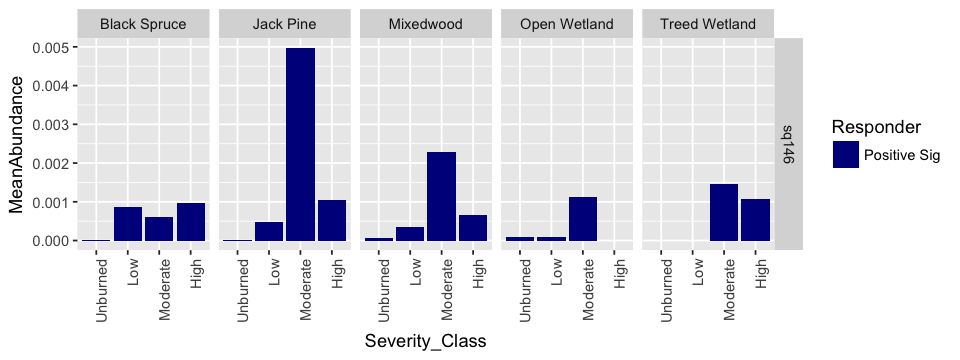

In [44]:
options(repr.plot.width=8, repr.plot.height=3)

d.plot = d.Exophiala%>%
    filter(OTU=="sq146")

p = ggplot(d.plot, aes(x=Severity_Class, y=MeanAbundance, fill=Responder))
#p = p +  geom_col(position="fill")
p = p +  geom_col()
p = p + scale_fill_manual(values=c("darkblue","lightblue","grey","pink","red"))
p = p + theme(axis.text.x = element_text(angle = 90, hjust=1))
#p = p + geom_abline(slope=0,intercept=0.5)
p = p + facet_grid(~OTU~Veg_Comm,labeller = label_wrap_gen(),scales="free_y")
p
# sq146, likely Exophiala xenobiotica, is very convincing, even though <1% of total comm at max. Still.

In [45]:
SaproEnrich = df.merged[df.merged$Guild=="Undefined Saprotroph" & !is.na(df.merged$Guild),]
SaproEnrich = SaproEnrich[SaproEnrich$Responder=="Positive Sig",]
levels(as.factor(SaproEnrich$OTU))
SaproEnrich = SaproEnrich%>%
    arrange(-MeanAbundance)
SaproEnrich
# It's all the Penicilliums
# spX matches Penicillium velutinum
# sqX matches Penicillium griseofulvum, Penicillium samsonianum, and Penicillium dipodomyicola   
# Some are also Ochrocladosporium - looks a bit like frigidarii or elatum (97% ID)
# Also see sqX Umbelopsis vinacea - multi-spored vs. near relatives - may be more of r-selected org?
# Some X Scutellinia - saprophytic; in Pyronema
# sqX looks like Exophiala xenobiotica: Environmental strains of E. xenobiotica are frequently found 
# in habitats rich in monoaromatic hydrocarbons and alkanes! (https://dx.doi.org/10.1007/s10482-006-9080-z)

[1] "sq11"  "sq113" "sq132" "sq14"  "sq146" "sq150" "sq163" "sq224" "sq247"
[10] "sq248" "sq259" "sq27"  "sq293" "sq371" "sq4"   "sq425" "sq427" "sq5"  
[19] "sq562" "sq570" "sq581"

OTU,Veg_Comm,Burned_Unburned,Severity_Class,Trophic.Mode,Guild,Responder,Phylum,Class,Order,Family,Genus,Species,MeanAbundance
sq5,Black Spruce,Burned,Moderate,Saprotroph,Undefined Saprotroph,Positive Sig,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Penicillium,,0.15607018
sq5,Jack Pine,Burned,Low,Saprotroph,Undefined Saprotroph,Positive Sig,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Penicillium,,0.14771683
sq5,Black Spruce,Burned,Low,Saprotroph,Undefined Saprotroph,Positive Sig,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Penicillium,,0.14504760
sq11,Treed Wetland,Burned,High,Saprotroph,Undefined Saprotroph,Positive Sig,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Penicillium,,0.12876433
sq4,Black Spruce,Burned,High,Saprotroph,Undefined Saprotroph,Positive Sig,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Penicillium,unidentified,0.11062554
sq5,Black Spruce,Burned,High,Saprotroph,Undefined Saprotroph,Positive Sig,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Penicillium,,0.10410769
sq4,Treed Wetland,Burned,High,Saprotroph,Undefined Saprotroph,Positive Sig,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Penicillium,unidentified,0.10406395
sq4,Mixedwood,Burned,High,Saprotroph,Undefined Saprotroph,Positive Sig,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Penicillium,unidentified,0.10063039
sq4,Mixedwood,Burned,Moderate,Saprotroph,Undefined Saprotroph,Positive Sig,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Penicillium,unidentified,0.10001945
sq4,Jack Pine,Burned,Moderate,Saprotroph,Undefined Saprotroph,Positive Sig,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Penicillium,unidentified,0.08473692


In [ ]:
SaproEnrich = df.merged[df.merged$Guild=="Fungal Pathogen" & !is.na(df.merged$Guild),]
SaproEnrich = SaproEnrich[SaproEnrich$Responder=="Positive Sig",]
levels(as.factor(SaproEnrich$OTU))
SaproEnrich = SaproEnrich%>%
    arrange(-MeanAbundance)
SaproEnrich
# It's all the Penicilliums
# sp3 matches Penicillium velutinum
# sq10 matches Penicillium griseofulvum, Penicillium samsonianum, and Penicillium dipodomyicola   
# Some are also Ochrocladosporium - looks a bit like frigidarii or elatum (97% ID)
# Also see sq105 Umbelopsis vinacea - multi-spored vs. near relatives - may be more of r-selected org?
# Some 276 Scutellinia - saprophytic; in Pyronema
# sq138 looks like Exophiala xenobiotica: Environmental strains of E. xenobiotica are frequently found 
# in habitats rich in monoaromatic hydrocarbons and alkanes! (https://dx.doi.org/10.1007/s10482-006-9080-z)

In [206]:
EricoidLoss = df.merged[df.merged$Guild=="Ericoid Mycorrhizal" & !is.na(df.merged$Guild),]
EricoidLoss = EricoidLoss[EricoidLoss$Responder=="Positive Sig",]
levels(as.factor(EricoidLoss$OTU))
# The enzymatic abilities and acidophilic nature of ericoid mycorrhizal Oidiodendron species may 
# partially explain the success of their host plants in acidic nutrient-poor soils (Rice & Currah 2001, in press).
# Best NCBI match is O. rhodogenum (100% ID, 100% coverage), known to have pH optima <5
    # Only O. maius maius is confirmed ericoid.
# sq22 matches Oidiodendron pilicola from UNITE db - non ecto
# MAY NOT BE ERICOID

[1] "sq18"  "sq21"  "sq302" "sq43"

In [207]:
d = tax_table(ps.norm)
d[row.names(d) %in% c('sq18' ,'sq21' ,'sq302' ,'sq43'),]

,Kingdom,Phylum,Class,Order,Family,Genus,Species,OTU_ID,Taxon,Taxon.Level,Trophic.Mode,Guild,Growth.Morphology,Confidence.Ranking,Notes,Citation.Source
sq18,,Ascomycota,Leotiomycetes,Leotiomycetes_ord_Incertae_sedis,Myxotrichaceae,Oidiodendron,,sq18,Oidiodendron,13,Pathotroph-Symbiotroph,Ericoid Mycorrhizal,Dark Septate Endophyte,Probable,NULL,Newsham 2011. New Phytologist 190:783-793 (as DSE)
sq21,,Ascomycota,Leotiomycetes,Leotiomycetes_ord_Incertae_sedis,Myxotrichaceae,Oidiodendron,,sq21,Oidiodendron,13,Pathotroph-Symbiotroph,Ericoid Mycorrhizal,Dark Septate Endophyte,Probable,NULL,Newsham 2011. New Phytologist 190:783-793 (as DSE)
sq43,,Ascomycota,Leotiomycetes,Leotiomycetes_ord_Incertae_sedis,Myxotrichaceae,Oidiodendron,,sq43,Oidiodendron,13,Pathotroph-Symbiotroph,Ericoid Mycorrhizal,Dark Septate Endophyte,Probable,NULL,Newsham 2011. New Phytologist 190:783-793 (as DSE)
sq302,,Ascomycota,Leotiomycetes,Leotiomycetes_ord_Incertae_sedis,Myxotrichaceae,Oidiodendron,,sq302,Oidiodendron,13,Pathotroph-Symbiotroph,Ericoid Mycorrhizal,Dark Septate Endophyte,Probable,NULL,Newsham 2011. New Phytologist 190:783-793 (as DSE)


In [146]:
PlantPath = df.merged[df.merged$Guild=="Plant Pathogen" & !is.na(df.merged$Guild),]
PlantPath = PlantPath[PlantPath$Responder=="Negative Sig",]
PlantPath
# Both American and English boxwood are susceptible to this disease caused by the fungus, 
# Pseudonectria rouselliana. The imperfect stage is Volutella buxi (best match for sq251 - Volutella). 
# Kills Pachysandra terminalis, Buxus sp., etc.

# This could represent a loss of boxwood or whatever its host is. Pretty dramatic.

OTU,Veg_Comm,Burned_Unburned,Severity_Class,Trophic.Mode,Guild,Responder,Phylum,Class,Order,Family,Genus,Species,MeanAbundance
sq251,Black Spruce,Burned,Low,Pathotroph,Plant Pathogen,Negative Sig,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Volutella,unidentified,4.923198e-05
sq251,Black Spruce,Burned,Moderate,Pathotroph,Plant Pathogen,Negative Sig,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Volutella,unidentified,4.513654e-05
sq251,Black Spruce,Burned,High,Pathotroph,Plant Pathogen,Negative Sig,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Volutella,unidentified,5.853986e-04
sq251,Black Spruce,Unburned,Unburned,Pathotroph,Plant Pathogen,Negative Sig,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Volutella,unidentified,4.302097e-03
sq251,Jack Pine,Burned,Low,Pathotroph,Plant Pathogen,Negative Sig,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Volutella,unidentified,0.000000e+00
sq251,Jack Pine,Burned,Moderate,Pathotroph,Plant Pathogen,Negative Sig,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Volutella,unidentified,4.241458e-06
sq251,Jack Pine,Burned,High,Pathotroph,Plant Pathogen,Negative Sig,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Volutella,unidentified,1.390134e-06
sq251,Jack Pine,Unburned,Unburned,Pathotroph,Plant Pathogen,Negative Sig,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Volutella,unidentified,1.572260e-03
sq251,Mixedwood,Burned,Low,Pathotroph,Plant Pathogen,Negative Sig,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Volutella,unidentified,0.000000e+00
sq251,Mixedwood,Burned,Moderate,Pathotroph,Plant Pathogen,Negative Sig,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Volutella,unidentified,2.732794e-04


In [196]:
EctoLoss = df.merged[df.merged$Guild=="Ectomycorrhizal" & !is.na(df.merged$Guild),]
EctoLoss = EctoLoss[EctoLoss$Responder=="Negative Sig",]
levels(as.factor(EctoLoss$OTU))
EctoLoss = EctoLoss%>%
    arrange(-MeanAbundance)
EctoLoss

[1] "sq108"

OTU,Veg_Comm,Burned_Unburned,Severity_Class,Trophic.Mode,Guild,Responder,Phylum,Class,Order,Family,Genus,Species,MeanAbundance
sq108,Treed Wetland,Burned,Moderate,Symbiotroph,Ectomycorrhizal,Negative Sig,Basidiomycota,Agaricomycetes,Agaricales,Cortinariaceae,Cortinarius,Cortinarius_diasemospermus,8.133940e-03
sq108,Mixedwood,Burned,High,Symbiotroph,Ectomycorrhizal,Negative Sig,Basidiomycota,Agaricomycetes,Agaricales,Cortinariaceae,Cortinarius,Cortinarius_diasemospermus,3.229488e-03
sq108,Mixedwood,Unburned,Unburned,Symbiotroph,Ectomycorrhizal,Negative Sig,Basidiomycota,Agaricomycetes,Agaricales,Cortinariaceae,Cortinarius,Cortinarius_diasemospermus,3.008016e-03
sq108,Jack Pine,Burned,High,Symbiotroph,Ectomycorrhizal,Negative Sig,Basidiomycota,Agaricomycetes,Agaricales,Cortinariaceae,Cortinarius,Cortinarius_diasemospermus,2.712173e-03
sq108,Mixedwood,Burned,Low,Symbiotroph,Ectomycorrhizal,Negative Sig,Basidiomycota,Agaricomycetes,Agaricales,Cortinariaceae,Cortinarius,Cortinarius_diasemospermus,1.235894e-03
sq108,Jack Pine,Unburned,Unburned,Symbiotroph,Ectomycorrhizal,Negative Sig,Basidiomycota,Agaricomycetes,Agaricales,Cortinariaceae,Cortinarius,Cortinarius_diasemospermus,4.363777e-04
sq108,Open Wetland,Burned,Low,Symbiotroph,Ectomycorrhizal,Negative Sig,Basidiomycota,Agaricomycetes,Agaricales,Cortinariaceae,Cortinarius,Cortinarius_diasemospermus,1.231475e-04
sq108,Black Spruce,Burned,High,Symbiotroph,Ectomycorrhizal,Negative Sig,Basidiomycota,Agaricomycetes,Agaricales,Cortinariaceae,Cortinarius,Cortinarius_diasemospermus,1.174281e-04
sq108,Jack Pine,Burned,Moderate,Symbiotroph,Ectomycorrhizal,Negative Sig,Basidiomycota,Agaricomycetes,Agaricales,Cortinariaceae,Cortinarius,Cortinarius_diasemospermus,8.187406e-05
sq108,Open Wetland,Burned,Moderate,Symbiotroph,Ectomycorrhizal,Negative Sig,Basidiomycota,Agaricomycetes,Agaricales,Cortinariaceae,Cortinarius,Cortinarius_diasemospermus,4.929508e-05


In [48]:
EctoEnrich = df.merged[df.merged$Guild=="Ectomycorrhizal" & !is.na(df.merged$Guild),]
#EctoEnrich = EctoEnrich[EctoEnrich$Responder=="Positive Sig" | EctoEnrich$Responder=="Positive",]
#levels(as.factor(EctoEnrich$OTU))
EctoEnrich = EctoEnrich%>%
    arrange(-MeanAbundance)
head(EctoEnrich)

OTU,Veg_Comm,Burned_Unburned,Severity_Class,Trophic.Mode,Guild,Responder,Phylum,Class,Order,Family,Genus,Species,MeanAbundance
sq34,Black Spruce,Burned,Low,Symbiotroph,Ectomycorrhizal,Not Tested,Basidiomycota,Agaricomycetes,Agaricales,Cortinariaceae,Cortinarius,Cortinarius_mucosus,0.18104447
sq133,Black Spruce,Unburned,Unburned,Symbiotroph,Ectomycorrhizal,Not Tested,Basidiomycota,Agaricomycetes,Agaricales,Cortinariaceae,Cortinarius,Cortinarius_saturninus,0.04938119
sq42,Mixedwood,Burned,Low,Symbiotroph,Ectomycorrhizal,Not Tested,Basidiomycota,Agaricomycetes,Agaricales,Inocybaceae,Inocybe,,0.03991014
sq59,Mixedwood,Unburned,Unburned,Symbiotroph,Ectomycorrhizal,Not Tested,Basidiomycota,Agaricomycetes,Agaricales,Inocybaceae,Inocybe,,0.03516006
sq203,Black Spruce,Burned,Low,Symbiotroph,Ectomycorrhizal,Not Tested,Basidiomycota,Agaricomycetes,Agaricales,Cortinariaceae,Cortinarius,Cortinarius_mucosus,0.03122640
sq36,Mixedwood,Burned,Low,Symbiotroph,Ectomycorrhizal,Not Tested,Basidiomycota,Agaricomycetes,Agaricales,Inocybaceae,Inocybe,,0.03120146


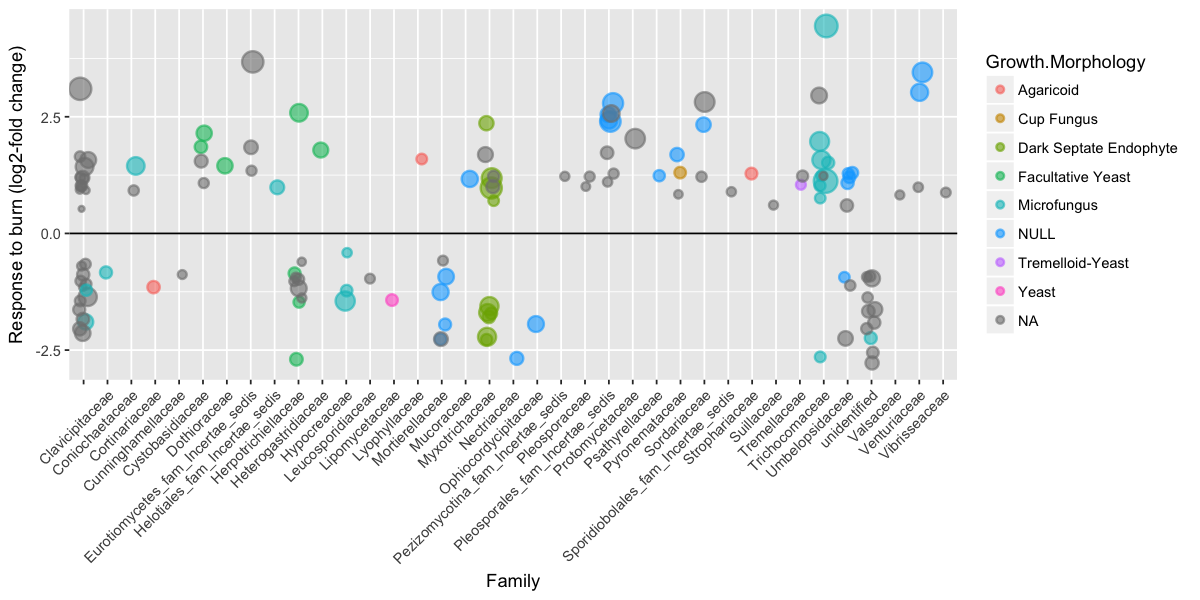

In [49]:
options(repr.plot.width=10, repr.plot.height=5)

df = results%>%
    filter(sigSeverity==1)
SigLevels = levels(droplevels(df$Growth.Morphology))
df = df %>%
    filter(Growth.Morphology %in% SigLevels | is.na(Growth.Morphology))

p = ggplot(df,aes(x=Family, y=logFC, color=Growth.Morphology,fill=Growth.Morphology))
p = p + geom_jitter(shape=21, stroke=1, aes(size=AveExpr), width=0.2, alpha=0.6)
p = p + theme(axis.text.x = element_text(angle=45, hjust=1))
#p = p + facet_wrap(scales="free")
p = p + theme(legend.position="right")
p = p + guides(size=FALSE)
#p = p + scale_color_manual(guide=guide_legend(ncol = 3))
p = p + geom_hline(yintercept=0) 
p = p + ylab("Response to burn (log2-fold change)")
p

In [295]:
#PosOTUs = df$OTU[df$logFC>0]
#NegOTUs = df$OTU[df$logFC<0]

In [296]:
OTUs = df$OTU
#saveRDS(OTUs,"CHTC/Dada2_Results_OA20_PEAR/CBI-resp-OTUs.rds")
saveRDS(PosOTUs,"CHTC/Dada2_Results_OA20_PEAR/CBI-resp-PosOTUs.rds")
saveRDS(NegOTUs,"CHTC/Dada2_Results_OA20_PEAR/CBI-resp-NegOTUs.rds")

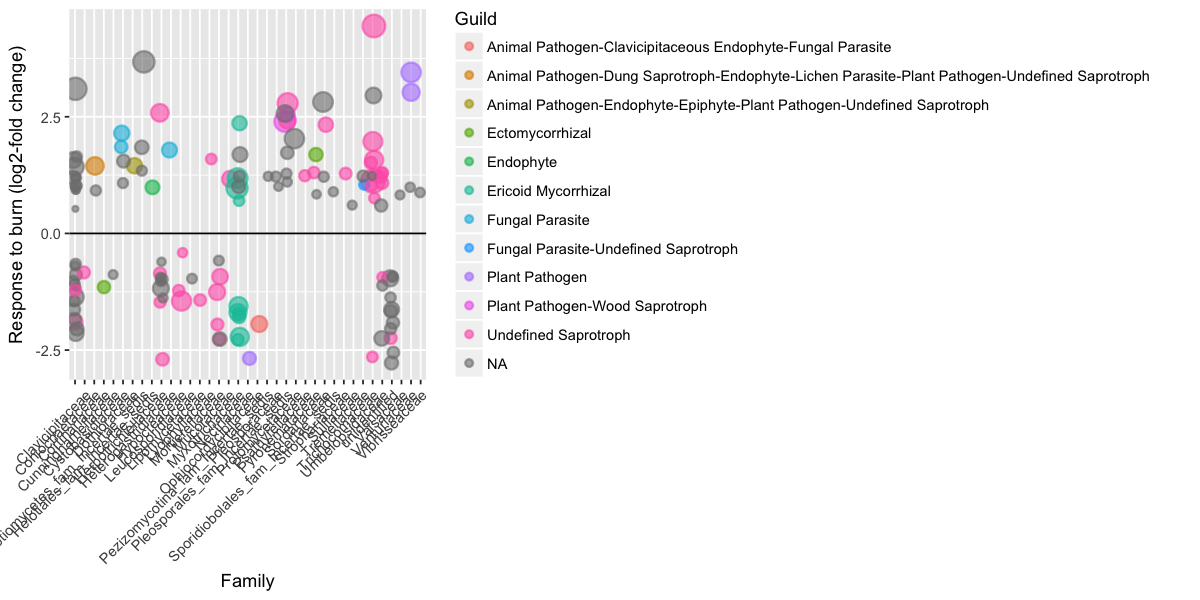

In [50]:
options(repr.plot.width=10, repr.plot.height=5)

df = results%>%
    filter(sigSeverity==1)
SigLevels = levels(droplevels(df$Guild))
df = df %>%
    filter(Guild %in% SigLevels | is.na(Guild))

p = ggplot(df,aes(x=Family, y=logFC, color=Guild,fill=Guild))
p = p + geom_jitter(shape=21, stroke=1, aes(size=AveExpr), width=0.2, alpha=0.6)
p = p + theme(axis.text.x = element_text(angle=45, hjust=1))
#p = p + facet_wrap(scales="free")
p = p + theme(legend.position="right")
p = p + guides(size=FALSE)
#p = p + scale_color_manual(guide=guide_legend(ncol = 3))
p = p + geom_hline(yintercept=0) 
p = p + ylab("Response to burn (log2-fold change)")
p

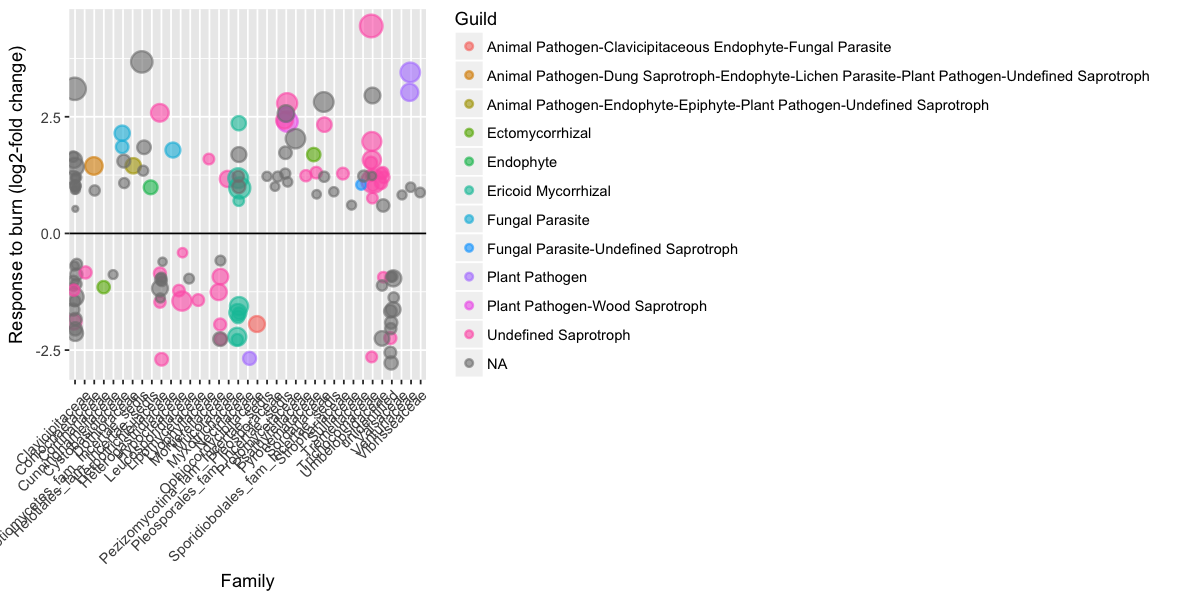

In [51]:
options(repr.plot.width=10, repr.plot.height=5)

df = results%>%
    filter(sigSeverity==1)
SigLevels = levels(droplevels(df$Guild))
df = df %>%
    filter(Guild %in% SigLevels | is.na(Guild))

p = ggplot(df,aes(x=Family, y=logFC, color=Guild,fill=Guild))
p = p + geom_jitter(shape=21, stroke=1, aes(size=AveExpr), width=0.2, alpha=0.6)
p = p + theme(axis.text.x = element_text(angle=45, hjust=1))
#p = p + facet_wrap(scales="free")
p = p + theme(legend.position="right")
p = p + guides(size=FALSE)
#p = p + scale_color_manual(guide=guide_legend(ncol = 3))
p = p + geom_hline(yintercept=0) 
p = p + ylab("Response to burn (log2-fold change)")
p

In [148]:
results[results$Family=="Gloniaceae",]
# https://www.nature.com/articles/ncomms12662
# "Cenococcum geophilum, the only mycorrhizal species within the largest fungal class Dothideomycetes, a class known for devastating plant pathogens."
# "The frequency with which this symbiont is found on tree roots and its possible role in water and nutrient transport in symbiosis calls for further studies on mechanisms of host and environmental adaptation."

[1] 17 25